In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [6]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [7]:
import pandas as pd
import numpy as np
import datetime
import os

In [8]:
# Custom functions
from useful_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_multilca_impacts_multidb, plot_contribution_analysis, plot_production_impacts, plot_incremental_impacts, plot_iwplus_contributions, plot_scenario_production_comparison

# Set projects, LCI and LCIA methods

In [9]:
BW_PROJECT = 'lib_rm' # insert your project name here
bd.projects.set_current(BW_PROJECT)
bd.databases

Databases dictionary with 7 object(s):
	LIB raw materials
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	image_26_2020
	image_26_2030
	image_26_2040
	image_26_2050

In [10]:
EI_DB = 'ecoinvent-3.10-cutoff'
LIB_RM_DB = 'LIB raw materials'
image_2020 = 'image_26_2020'
image_2030 = 'image_26_2030'
image_2040 = 'image_26_2040'
image_2050 = 'image_26_2050'
prospective_db = [image_2020, image_2030, image_2040, image_2050]

## Import LCI

In [11]:
INVENTORIES_CU = {
    "Copper mine operation": ('copper mine operation and beneficiation, sulfide ore', 'copper concentrate, sulfide ore', 'CA'),
    "Market for copper, cathode": ('market for copper, cathode', 'copper, cathode', 'GLO'),
}

In [12]:
INVENTORIES_NI = {
    "Nickel sulfate production": ("nickel sulfate production, average excluding China, economic allocation", "nickel sulfate", "GLO"),
    "Market for nickel, class 1": ("market for nickel, class 1", "nickel, class 1", "GLO")
}

In [13]:
INVENTORIES_LI = {
    "Lithium hydroxide, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium hydroxide, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Lithium carbonate, brine":        ("lithium carbonate production, Salar de Atacama", "lithium carbonate, battery grade", "CL"),
    "Lithium carbonate, spodumene":    ("lithium carbonate production, from Australian spodumene", "lithium carbonate, battery grade", "CN"),
    "Market for lithium carbonate": ("market for lithium carbonate, battery grade", "lithium carbonate, battery grade", "GLO")
}

## Pick LCIA methods

In [14]:
# We can also import some from IW+2.1
iw_ei310 = 'data/IW+2.1/impact_world_plus_21_brightway2_expert_version_ei310.5535d12bedce3770ffef004e84229fd1.bw2package'
bw.BW2Package.import_file(iw_ei310)

[Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, short term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, long term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Fisheries impact,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Fossil and nuclear energy use,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Mid

In [15]:
# Filter and display methods that contain "IMPACT World+" in their names
iw_methods = [method for method in bd.methods if "impact world+" in " ".join(method).lower()]
df_iw_methods = pd.DataFrame(iw_methods, columns=["Method", "Impact Category", "Subcategory"])
#df_iw_methods.to_csv(r'data/iw_methods.csv', index=False)

In [16]:
ipcc_methods = [method for method in bd.methods if "ipcc 2021" in " ".join(method).lower()]
ipcc_methods

[('IPCC 2021 no LT',
  'climate change no LT',
  'global temperature change potential (GTP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global temperature change potential (GTP50) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP20) no LT'),
 ('IPCC 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP500) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global temperature change potential (GTP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global temperature change potential (GTP50) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP20) no LT'),
 ('IPCC 2021 no LT',
  'climate change: biogenic no LT',
  'global warming potentia

In [17]:
IMPACT_METHODS = {
    'GWP100': ('IPCC 2021 no LT', 'climate change no LT','global warming potential (GWP100) no LT'),
    'GTP100': ('IPCC 2021 no LT','climate change no LT', 'global temperature change potential (GTP100) no LT')
}

# Calculate specific impacts (e.g. per mass)

In [18]:
def calculate_specific_lca_results(prospective_db, INVENTORIES, IMPACT_METHODS):
    """
    Calculates LCA results for each database in `prospective_db`.

    Parameters:
    - prospective_db (list): List of database names to iterate over.
    - INVENTORIES (dict): Dictionary of inventories to search in each database.
    - IMPACT_METHODS (dict): Dictionary of impact methods with names and method tuples.
    - get_inventory_dataset (function): Function to get inventory datasets for specified databases.
    - init_simple_lca (function): Function to initialize the LCA for specified activity.
    - multi_lcia (function): Function to calculate multiple impact categories.

    Returns:
    - dict: Dictionary of DataFrames with LCA results for each database.
    """
    # Initialize the dictionary to store results for each database
    specific_lca_results = {}

    # Iterate over each database
    for db_name in prospective_db:
        # Get inventory datasets from the specific database
        INVENTORIES_ds = get_inventory_dataset(INVENTORIES, [db_name])  # Pass as a list to search only in the current db

        # Dictionary to store LCA results for each raw material in the current database
        specific_lca = {}

        # Check if INVENTORIES_ds has results for the current database
        if INVENTORIES_ds:
            for rm, activity in INVENTORIES_ds.items():
                try:
                    # Initialize the LCA object without specifying a method
                    lca = init_simple_lca(activity)

                    # Calculate multiple impacts using `multi_lcia` with specified impact methods
                    impacts = multi_lcia(lca, activity, IMPACT_METHODS)

                    # Store the impacts for the current raw material
                    specific_lca[rm] = impacts

                except Exception as e:
                    print(f"Error processing {db_name} for {rm}: {e}")

            # Convert the specific LCA results for the current database to a DataFrame and store it
            specific_lca_results[db_name] = pd.DataFrame(specific_lca).T
        else:
            print(f"No inventory data found for database: {db_name}")

    return specific_lca_results


In [19]:
df_cu = calculate_specific_lca_results(prospective_db, INVENTORIES_CU, IMPACT_METHODS)
df_ni = calculate_specific_lca_results(prospective_db, INVENTORIES_NI, IMPACT_METHODS)
df_li = calculate_specific_lca_results(prospective_db, INVENTORIES_LI, IMPACT_METHODS)

Plot saved to results/prospective_results/cu.png
Plot saved to results/prospective_results/ni.png
Plot saved to results/prospective_results/li.png


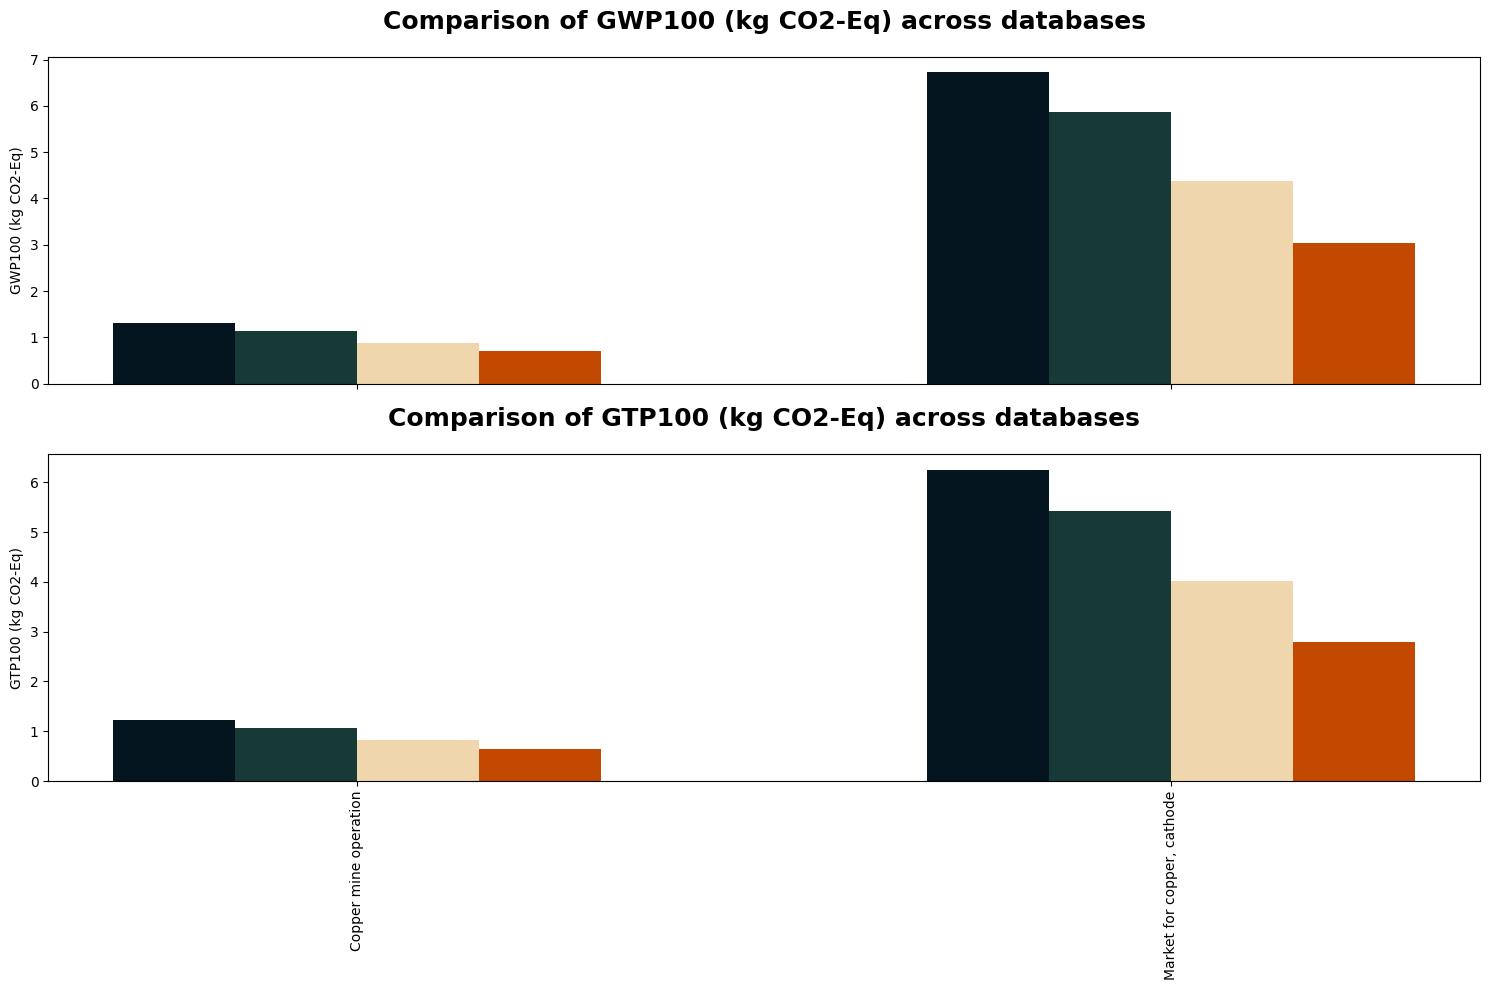

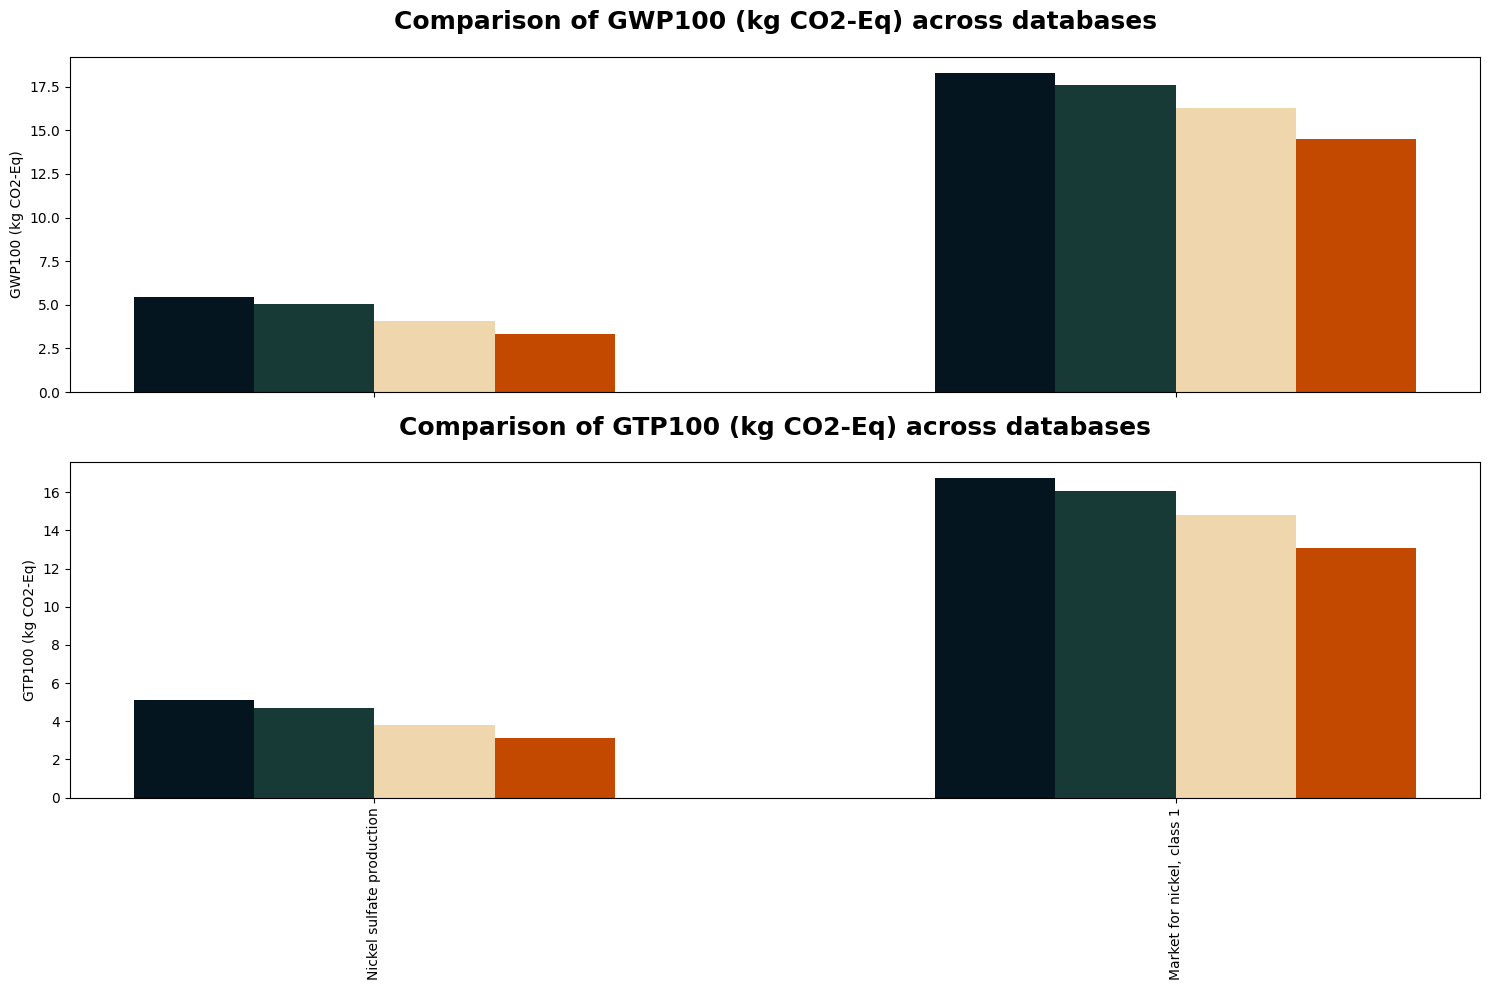

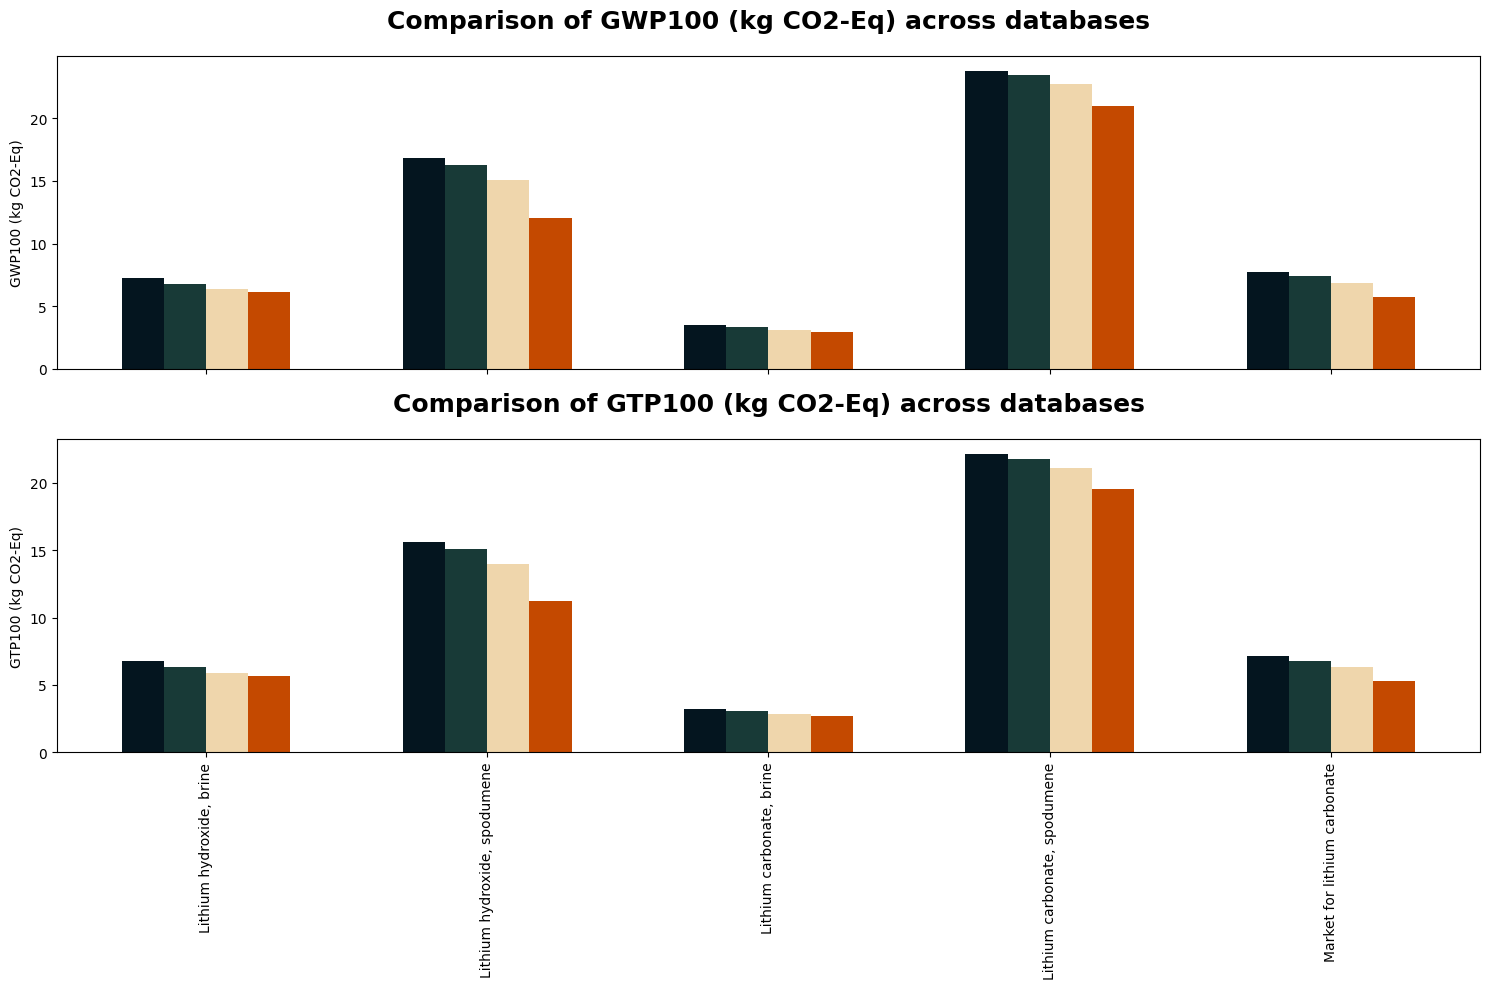

In [20]:
db_colors = {
    'image_26_2020': '#04151f',
    'image_26_2030': '#183a37',
    'image_26_2040': '#efd6ac',
    'image_26_2050': '#c44900'
}

plot_multilca_impacts_multidb(df_cu, db_colors=db_colors, save_path="results/prospective_results/cu.png")
plot_multilca_impacts_multidb(df_ni, db_colors=db_colors, save_path="results/prospective_results/ni.png")
plot_multilca_impacts_multidb(df_li, db_colors=db_colors, save_path="results/prospective_results/li.png")

In [21]:
def calculate_contribution_analysis(prospective_db, INVENTORIES, IMPACT_METHODS, top_n=10, threshold=0.01):
    """
    Perform contribution analysis for each inventory in each database.

    Parameters:
    - prospective_db (list): List of database names to iterate over.
    - INVENTORIES (dict): Dictionary of inventories to search in each database.
    - IMPACT_METHODS (dict): Dictionary of impact methods with names and method tuples.
    - get_inventory_dataset (function): Function to get inventory datasets for specified databases.
    - init_simple_lca (function): Function to initialize the LCA for specified activity.
    - multi_contribution_analysis (function): Function to perform contribution analysis.
    - top_n (int): Number of top processes to include in the contribution analysis (default is 10).
    - threshold (float): Minimum percentage contribution to include in the results (default is 0.01).

    Returns:
    - pd.DataFrame: Combined DataFrame of contribution analysis results across all databases and inventories.
    """
    # Initialize a dictionary to store contribution analysis results by database
    all_contribution_results = {}

    # Loop through each database
    for db_name in prospective_db:
        # Get inventory datasets from the specific database
        INVENTORIES_ds = get_inventory_dataset(INVENTORIES, [db_name])

        # Dictionary to store contribution results for each inventory in the current database
        contribution_results = {}

        # Perform contribution analysis for each inventory in the current database
        if INVENTORIES_ds:
            for rm_name, rm_ds in INVENTORIES_ds.items():
                try:
                    # Initialize the LCA object
                    lca = init_simple_lca(rm_ds)

                    # Perform the contribution analysis for the current inventory
                    contributions = multi_contribution_analysis(lca, IMPACT_METHODS, top_n=top_n, threshold=threshold)
                    contribution_results[rm_name] = contributions

                except Exception as e:
                    print(f"Error performing contribution analysis for {rm_name} in {db_name}: {e}")

            # Store the contribution results for the current database
            all_contribution_results[db_name] = contribution_results
        else:
            print(f"No inventory data found for database: {db_name}")

    # Convert the results into DataFrames for easy analysis
    contribution_dfs = {}

    # Organize the results into DataFrames
    for db_name, db_contributions in all_contribution_results.items():
        for rm_name, impacts in db_contributions.items():
            for impact_name, contributions in impacts.items():
                df = pd.DataFrame(contributions)
                df["Database"] = db_name
                df["Inventory"] = rm_name
                df["Impact Category"] = impact_name
                contribution_dfs[(db_name, rm_name, impact_name)] = df

    # Combine all individual DataFrames into one for easy viewing and analysis
    contribution_analysis_df = pd.concat(contribution_dfs.values(), ignore_index=True)

    # Set "Database", "Inventory", and "Impact Category" as the row indices
    contribution_analysis_df.set_index(["Database", "Inventory", "Impact Category"], inplace=True)

    return contribution_analysis_df


In [22]:
ca_cu = calculate_contribution_analysis(prospective_db, INVENTORIES_CU, IMPACT_METHODS)
ca_li = calculate_contribution_analysis(prospective_db, INVENTORIES_LI, IMPACT_METHODS)
ca_ni = calculate_contribution_analysis(prospective_db, INVENTORIES_NI, IMPACT_METHODS)

In [49]:
ca_cu

score  quantity  \
Database      Inventory                  Impact Category                       
image_26_2020 Copper mine operation      GWP100           0.127006  0.114668   
                                         GWP100           0.092758  0.805962   
                                         GWP100           0.073021  0.065927   
                                         GWP100           0.052079  1.000313   
                                         GWP100           0.043178  0.106689   
...                                                            ...       ...   
image_26_2050 Market for copper, cathode GTP100           0.064965  1.101337   
                                         GTP100           0.055448  0.828105   
                                         GTP100           0.055013  0.085209   
                                         GTP100           0.051786  0.064042   
                                         GTP100           0.048666  0.057316   

                                                          percentage  \
Database      Inventory                  Impact Category               
image_26_2020 Copper mine operation      GWP100             9.639142   
                                         GWP100             7.039870   
                                         GWP100             5.541957   
                                         GWP100             3.952544   
                                         GWP100             3.277031   
...                                                              ...   
image_26_2050 Market for copper, cathode GTP100             2.330308   
                                         GTP100             1.988938   
                                         GTP100             1.973331   
                                         GTP100             1.857564   
                                         GTP100             1.745638   

                                                                                                       name  \
Database      Inventory                  Impact Category                                                      
image_26_2020 Copper mine operation      GWP100                             electricity production, lignite   
                                         GWP100           heat production, at hard coal industrial furna...   
                                         GWP100                             electricity production, lignite   
                                         GWP100           copper mine operation and beneficiation, sulfi...   
                                         GWP100           hard coal mine operation and hard coal prepara...   
...                                                                                                     ...   
image_26_2050 Market for copper, cathode GTP100           heat production, natural gas, at industrial fu...   
                                         GTP100                            sweet gas, burned in gas turbine   
                                         GTP100           heat and power co-generation, natural gas, con...   
                                         GTP100                                          clinker production   
                                         GTP100                                         pig iron production   

                                                                                          reference product  
Database      Inventory                  Impact Category                                                     
image_26_2020 Copper mine operation      GWP100                                   electricity, high voltage  
                                         GWP100           heat, district or industrial, other than natur...  
                                         GWP100                                   electricity, high voltage  
                                         GWP100                             copper concen

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_contribution_analysis(df, inventory_names=None, colors=None, save_dir="results"):
    """
    Plot contribution analysis for multiple databases for each inventory, allowing comparison between databases.
    Each inventory's impact categories are plotted in a single figure with grouped bars for each database.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the contribution analysis data.
    - inventory_names (list of str, optional): List of inventory names to filter and plot. If None, plot all inventories.
    - colors (list of str): List of colors for each impact category.
    - save_dir (str): Directory to save the plot images. Default is "results".
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Reset index to access "Database" and "Inventory" columns
    df = df.reset_index()

    # Filter the DataFrame for the specific inventories, if provided
    if inventory_names:
        df = df[df['Inventory'].isin(inventory_names)]

    # Loop through each inventory
    for inventory_name in df['Inventory'].unique():
        df_inventory = df[df['Inventory'] == inventory_name]

        # List of unique impact categories for the inventory
        impact_categories = df_inventory['Impact Category'].unique()
        databases = df_inventory['Database'].unique()

        # Set up figure with subplots for each impact category
        fig, axes = plt.subplots(len(impact_categories), 1, figsize=(12, len(impact_categories) * 2.5), sharex=True)
        if len(impact_categories) == 1:
            axes = [axes]  # Ensure axes is iterable when there is only one category

        # Create color dictionary for databases
        color_dict = {db: colors[i % len(colors)] for i, db in enumerate(databases)}

        # Plot each impact category with grouped bars for each database
        for i, impact_category in enumerate(impact_categories):
            ax = axes[i]
            df_category = df_inventory[df_inventory['Impact Category'] == impact_category]

            # Collect reference products and contributions for each database
            reference_products = df_category['reference product'].unique()
            bar_width = 0.15  # Width of each bar

            for j, db_name in enumerate(databases):
                df_db = df_category[df_category['Database'] == db_name]
                db_values = [df_db[df_db['reference product'] == product]['percentage'].values[0] if product in df_db['reference product'].values else 0
                             for product in reference_products]

                # Set x positions for each database in the group
                x_positions = np.arange(len(reference_products)) + j * bar_width
                ax.barh(x_positions, db_values, height=bar_width, label=db_name, color=color_dict[db_name], edgecolor='black')

            # Set plot labels and title
            ax.set_yticks(np.arange(len(reference_products)) + (len(databases) - 1) * bar_width / 2)
            ax.set_yticklabels(reference_products)
            ax.invert_yaxis()  # To have the highest contributions on top
            ax.set_title(f"{impact_category} - {inventory_name}")
            ax.set_xlabel("Contribution (%)")
            ax.set_ylabel("Reference Product")

        # Add legend and adjust layout
        fig.legend(databases, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(databases), title="Databases")
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Save each plot to the specified directory with a filename based on the inventory name
        save_path = os.path.join(save_dir, f"{inventory_name}_contribution_comparison.png")
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"Plot saved to {save_path}")
        plt.close(fig)


In [53]:
plot_contribution_analysis(ca_cu, 
                           inventory_names=['Copper mine operation', 'Market for copper, cathode'],
                           colors=["#04151f", "#183a37", "#efd6ac", "#c44900"],
                           save_dir="results/prospective_results/")

Plot saved to results/prospective_results/Copper mine operation_contribution_comparison.png
Plot saved to results/prospective_results/Market for copper, cathode_contribution_comparison.png


In [57]:
plot_contribution_analysis(ca_li, 
                           inventory_names=['Lithium hydroxide, brine', 'Lithium hydroxide, spodumene',
                            'Lithium carbonate, brine', 'Lithium carbonate, spodumene',
                            'Market for lithium carbonate'],
                           colors=["#04151f", "#183a37", "#efd6ac", "#c44900"],
                           save_dir="results/prospective_results/")

Plot saved to results/prospective_results/Lithium hydroxide, brine_contribution_comparison.png
Plot saved to results/prospective_results/Lithium hydroxide, spodumene_contribution_comparison.png
Plot saved to results/prospective_results/Lithium carbonate, brine_contribution_comparison.png
Plot saved to results/prospective_results/Lithium carbonate, spodumene_contribution_comparison.png
Plot saved to results/prospective_results/Market for lithium carbonate_contribution_comparison.png


In [61]:
plot_contribution_analysis(ca_ni, 
                           inventory_names=['Nickel sulfate production', 'Market for nickel, class 1'],
                           colors=["#04151f", "#183a37", "#efd6ac", "#c44900"],
                           save_dir="results/prospective_results/")

Plot saved to results/prospective_results/Nickel sulfate production_contribution_comparison.png
Plot saved to results/prospective_results/Market for nickel, class 1_contribution_comparison.png
